# Spreading Out

## 2D Heat Conduction
The equation of heat conduction in 2D is:

$$
\begin{equation}
\rho c_p \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( \kappa_x \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left(\kappa_y \frac{\partial T}{\partial y} \right)
\end{equation}
$$

where $\rho$ is the density, $c_p$ is the heat capacity and $\kappa$ is the thermal conductivity.

If the thermal conductivity $\kappa$ is constant, then we can take it outside of the spatial derivative and the equation simplifies to:

$$
\begin{equation}
\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)
\end{equation}
$$

where $\alpha = \frac{\kappa}{\rho c_p}$ is the thermal diffusivity.  The thermal diffusivity describes the ability of a material to conduct heat vs. storing it.

### Problem

Consider a micro-chip as a 2D plate of
- size 1 cm x 1 cm,
- made of Silicon
    - $\kappa = 159{\rm W/m C}$,
    - $c_p = 0.712\cdot 10^3 {\rm J/kg C}$,
    - $\rho = 2329{\rm kg/m}^3$, and
    - diffusivity $\alpha \approx 10^{-4}{\rm m}^2{/\rm s}$.
- Silicon melts at $1414 {\rm C}$, but chips should of course operate at much smaller temperatures. The maximum temperature allowed depends on the processor make and model; in many cases, the maximum temperature is somewhere between $60{\rm C}$ and $\sim70{\rm C}$, but better CPUs are recommended to operate at a maximum of $80{\rm C}$, (like the Intel Core i7, for example).

### 2D Finite Differences

We will use a 2D Cartesian grid: one that consists of two families of (grid) lines parallel to the two spatial directions. Two lines (of different families) intersect on one and only one grid node (this is called a _structured_ grid).

In the $x$ direction, the discretization uses $i=0, \cdots N_x$ lines.

In the $y$ direction, we have $j=0, \cdots N_y$ lines.

A given node on the grid will now have two spatial coordinates, and we need two indices: for the two lines that intersect at that node.  For example, the middle point in the figure below would be $T_{i,j}$.

### Explicit Scheme in 2D
Discretized using forward difference in time, and central difference in space,  using an explicit scheme:
$$
\begin{equation}
\frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = \alpha \left( \frac{T^n_{i+1, j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i, j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2}\right)
\end{equation}
$$

Rearranging the equation to solve for the value at the next time step, $T^{n+1}_{i,j}$, yields

$$
\begin{equation}
T^{n+1}_{i,j}= T^n_{i,j} + \alpha \left( \frac{\Delta t}{\Delta x^2} (T^n_{i+1, j} - 2T^n_{i,j} + T^n_{i-1,j}) + \\\frac{\Delta t}{\Delta y^2} (T^n_{i, j+1} - 2T^n_{i,j} + T^n_{i,j-1})\right)
\end{equation}
$$

Similar to all of the 1D explicit methods we've used, the solution at $T^{n+1}_{i,j}$ is updated using only known values from the current solution at time $n$. This is straightforward to implement in code, but will be subject to stability limitations on the time step that you can choose.

### Boundary Conditions
If the boundary has Dirichlet conditions, we simply impose the prescribed temperature at that point. If the boundary has Neumann conditions, we approximate them with a finite-difference scheme.

Remember, Neumann boundary conditions prescribe the derivative in the normal direction.

We have $\frac{\partial T}{\partial y} = q_y$ in the top boundary and $\frac{\partial T}{\partial x} = q_x$ in the right boundary, with $q_y = q_x = 0$ (insulation).

Thus, at every time step, we need to enforce

$$
\begin{equation}
T_{i,end} = q_y\cdot\Delta y + T_{i,end-1}
\end{equation}
$$

and

$$
\begin{equation}
T_{end,j} = q_x\cdot\Delta x + T_{end-1,j}
\end{equation}
$$

### Stability 
In 2D stability constraints, we need to add them in both directions: 

$$
\begin{equation}
\alpha \frac{\Delta t}{(\Delta x)^2} + \alpha \frac{\Delta t}{(\Delta y)^2} < \frac{1}{2}.
\end{equation}
$$

Say that the mesh has the same spacing in $x$ and $y$, $\Delta x = \Delta y = \delta$. In that case, the stability condition is:

$$
\begin{equation}
\alpha \frac{\Delta t}{\delta^2} < \frac{1}{4}
\end{equation}
$$

## Code

In [1]:
import numpy as np
from matplotlib import pyplot as py
%matplotlib inline

# Font family and size to use for Matplotlib figures.
py.rcParams['font.family'] = 'serif'
py.rcParams['font.size'] = 16

In [2]:
'''
    Computes the temperature distribution with the given number
        of time steps.
    Explicit integration using forward differencing in time and
        central differincing in space, with Neumann conditions
        (zero-gradient) on top and right boundaries and
        Dirichlet conditions on bottom and left boundaries.
        
    T0 : np.ndarray, initial temperature distribution
    nt : integer, max number of time steps to compute
    dt : float, time-step size
    dx : float, grid spacing in the x - direction
    dy : float, grid spacing in the y - direction
    alpha : float, thermal diffusivity
    
    Returns:
    T : np.ndarray, temperature distribution as a 2D 
            array of floats
'''

def ftcs(t0, nt, dt, dx, dy, alpha):
    # Constants
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2
    
    # Integrate in time
    T = T0.copy()
    ny, nx = T.shape
    I, J = int(nx/2), int(ny/2)   # indices of the center
    for n in range(nt):
        T[1:-1, 1:-1] = (T[1:-1, 1:-1] +
            sigma_x * (T[1:-1, 2:] - 2.0 * T[1:-1, 1:-1] + T[1:-1, :-2]) +
            sigma_y * (T[2:, 1:-1] - 2.0 * T[1:-1, 1:-1] + T[:-2, 1:-1]))
        # Neumann Conditions (zero-gradient)
        T[-1, :] = T[-2, :]
        T[:, -1] = T[:, -2]
        # Check if the center of the domain has reached T = 70 C
        if T[J, I] >= 70.0:
            break
    print('[Time Step {}] Center at T = {:.2f} at t = {:.2f} s'
        .format(n + 1, T[J, I], (n + 1) * dt))
    
    return T

The `break` statement exits the `for` loop at the closest time iteration when the plate reaches 70 C.

In [3]:
# Parameters
Lx = 0.01   # length of the plate in the x direction
Ly = 0.01   # height of the plate in the y direction
nx = 21   # number of points in the x direction
ny = 21   # number of points in the y direction
dx = Lx / (nx - 1)   # grid spacing in the x direction
dy = Ly / (ny - 1)   # grid spacing in the y direction
alpha = 1e-4   # thermal diffusivity of the plate

# Locations along a gridline
x = np.linspace(0.0, Lx, num = nx)
y = np.linspace(0.0, Ly, num = ny)

# Initial temperature distribution
Tb = 100.0   # temperature at the left and bottom boundaries
T0 = 20.0 * np.ones((ny, nx))
T0[0, :] = Tb
T0[:, 0] = Tb

Time step with $\frac{\alpha \Delta t}{\Delta x^2} = \frac{\alpha \Delta t}{\Delta y^2} = \frac{1}{4}$: 

In [4]:
# Time-step size based on CFL limit of sigma = 0.25
sigma = 0.25
dt = sigma * min(dx, dy)**2 / alpha   # time-step size
nt = 500   # number of time steps to compute

# Temperature along the rod
T = ftcs(T0, nt, dt, dx, dy, alpha)

[Time Step 256] Center at T = 70.02 at t = 0.16 s


## Results Visualization
`pyplot.contourf` produces a contour plot. ('f' denotes "filled" contours)

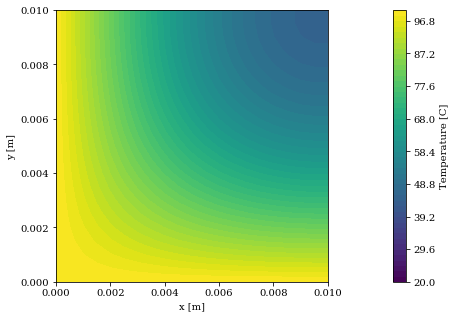

In [5]:
# Filled contour of the temperature
py.figure(figsize = (8.0, 5.0))
py.xlabel('x [m]')
py.ylabel('y [m]')
levels = np.linspace(20.0, 100.0, num = 51)
contf = py.contourf(x, y, T, levels = levels)
cbar = py.colorbar(contf)
cbar.set_label('Temperature [C]')
py.axis('scaled', adjustable = 'box');